Goal: Clustering using Spectral Clustering

**Navigation:**
- [Part 1: Data Exploration](#part-1-data-exploration)
- [Part 2: Feature engineering](#part-2-feature-engineering)
- [Part 3: Spectral Clustering Implementation](#part-3-spectral-clustering-implementation)
- [Part 4: Params Tuning](#part-4-params-tuning)

In [1]:
# Import libraries
import pandas as pd

# Visualization imports
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Variable Information

For what purpose was the dataset created?
- Product classification, clustering and entity matching.
- Short-text clustering algorithms.

# 7 Features
1. Product ID (Integer)
2. Product Title (Categorical)
3. Merchant ID (Integer)
4. Cluster ID (Integer)
5. Cluster Label (Categorical)
6. Category ID (Integer)
7. Category Label (Categorical)

In [2]:
# Read dataset
products = pd.read_csv('data/products.csv')

## Part 1: Data Exploration


In [3]:
# Display basic information about the dataset
print("Dataset Shape:", products.shape)
print("\nDataset Info:")
products.info()
products.head()

Dataset Shape: (35311, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [4]:
# Remove spaces from column names
products.columns = products.columns.str.replace(' ', '')

# Number of unique categories and clusters
num_categories = products['CategoryID'].nunique()
num_clusters = products['ClusterID'].nunique()
print(f'Number of unique categories: {num_categories}'
      f'\nNumber of unique clusters: {num_clusters}')

Number of unique categories: 10
Number of unique clusters: 13233


Text(0, 0.5, 'Frequency')

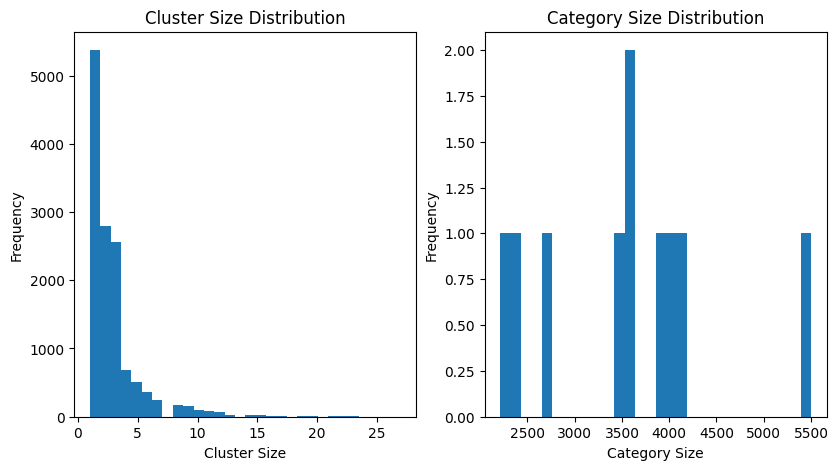

In [5]:
plt.figure(figsize=(15, 5))
category_dist = products['CategoryID'].value_counts()
cluster_dist = products['ClusterID'].value_counts()

# Cluster size distribution
plt.subplot(131)
plt.hist(cluster_dist, bins=30)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')

# Category size distribution
plt.subplot(132)
plt.hist(category_dist, bins=30)
plt.title('Category Size Distribution')
plt.xlabel('Category Size')
plt.ylabel('Frequency')


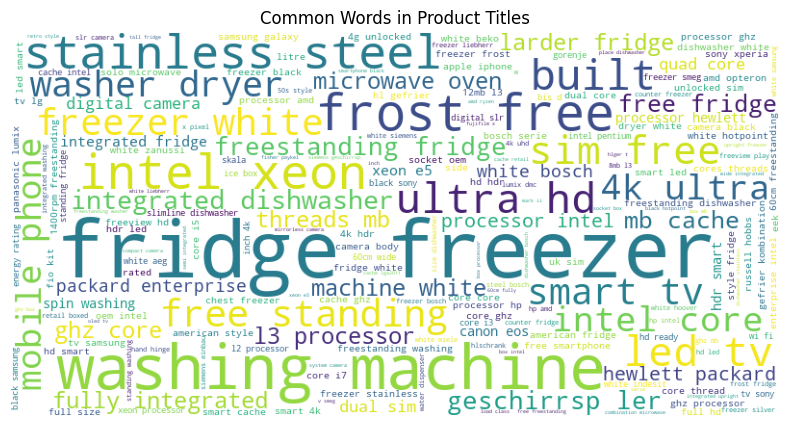

In [6]:
# Word cloud of product titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(products['ProductTitle']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common Words in Product Titles')
plt.show()

# Part 2: Feature engineering
### Prepare the features for spectral clustering by:
- Clean the text data (Since we're working with product titles (text data))
- Convert text to numerical features using TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    """Clean the text by removing special characters and converting to lowercase"""
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters
    # text = re.sub(r'[^a-zA-Z\s]', '', text) 
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Clean the product titles
products['cleaned_title'] = products['ProductTitle'].apply(clean_text)

[nltk_data] Downloading package stopwords to C:\Users\Yee Khai
[nltk_data]     Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Yee Khai
[nltk_data]     Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 3: Spectral Clustering Implementation
- Use sparse kNN graph
- Set the number of clusters equal to the true number of clusters
- Evaluate the clustering using multiple metrics:
    - Adjusted Rand Index (ARI)
    - Normalized Mutual Information (NMI)
    - Silhouette Score
- Visualize the results using t-SNE dimensionality reduction

The evaluation metrics help us understand:
- How well our clusters match the ground truth (ARI, NMI)
- How well-separated our clusters are (Silhouette Score)

Note:
- Use t-SNE to reduce the high-dimensional TF-IDF features to 2D for visualization
- Creates side-by-side plots showing:
    - True clusters from the original data
    - Predicted clusters from spectral clustering

c:\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Clustering Performance Metrics:
Adjusted Rand Index: 0.004
Normalized Mutual Information: 0.073
Silhouette (cosine on TF-IDF): -0.090


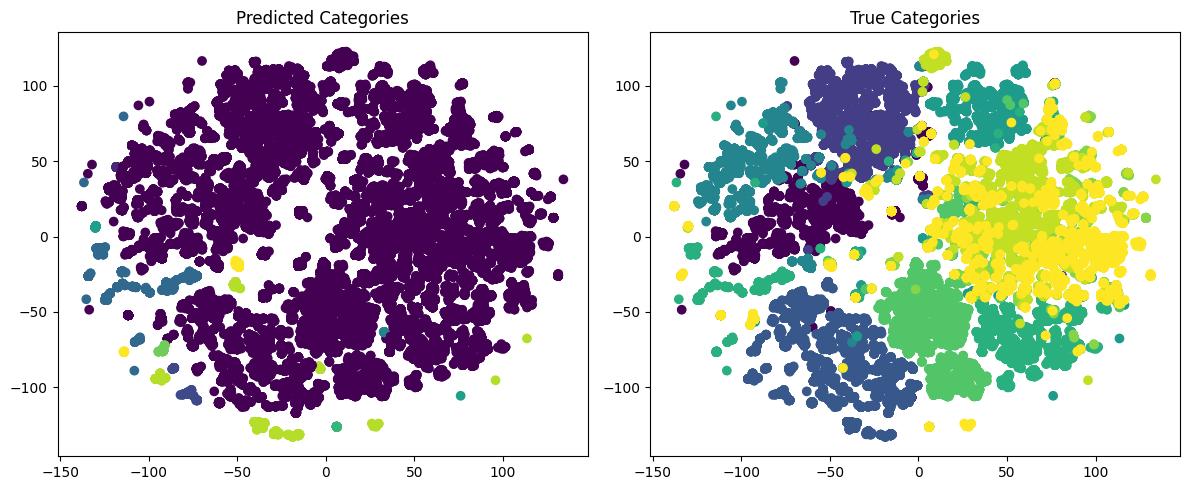

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np

# 1) TF-IDF (keep sparse)
tfidf = TfidfVectorizer(
    max_features=100, # We're using max_features=100 to limit the vocabulary size
    stop_words='english',
    min_df=5 # The min_df parameter removes rare terms
)
X = tfidf.fit_transform(products['cleaned_title'])

# 2) Build sparse k-NN graph (symmetrized)
A = kneighbors_graph(
    X, 
    n_neighbors=20, 
    mode="connectivity", 
    metric="cosine", 
    include_self=False, 
    n_jobs=1
    )
A = A.maximum(A.T)  # make symmetric

# 3) Spectral clustering on sparse affinity
n_clusters = products['CategoryID'].nunique()
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans', # default
    random_state=42
)
labels = spectral.fit_predict(A)

# 4) Evaluation (use features or precomputed distances correctly)
ari = adjusted_rand_score(products['CategoryID'], labels)
nmi = normalized_mutual_info_score(products['CategoryID'], labels)

# Silhouette on features using cosine distance (works with sparse X)
sil = silhouette_score(X, labels, metric='cosine')

print("Clustering Performance Metrics:")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")
print(f"Silhouette (cosine on TF-IDF): {sil:.3f}")

# Visualize results using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Plot predicted clusters
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
plt.title('Predicted Categories')

# Plot true clusters
plt.subplot(122)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=products['CategoryID'], cmap='viridis')
plt.title('True Categories')

plt.tight_layout()
plt.show()

# Part 4: Params Tuning

Tests different combinations of important parameters to optimize these 2 *metrics*:

1. **Adjusted Rand Index (ARI)**
    - Measures how similar predicted clusters are to the true labels, adjusting for chance.  
    - **Range:** [-1, 1]  
    - Evaluates how often two samples are grouped together or apart in both clusterings (pairwise agreements).  
    - Penalizes both over-segmentation and under-segmentation (too many or too few clusters).  

2. **Normalized Mutual Information (NMI)**
    - Measures the amount of shared information between predicted clusters and true categories.  
    - **Range:** [0, 1]  
    - Less harsh than ARI since it focuses on overall information overlap rather than exact pairwise matches.  
    - Symmetric and stable, works well for assessing high-level alignment between clusters and real categories.  

Since we have ground truth labels (`CategoryID`), we **prioritize ARI** as the strictest and most interpretable check for correctness.  
We use **NMI** to gauge general topic overlap as it can appear strong even when ARI is relatively low.

---

### Parameters Tested

| Parameter | Description | Why it’s Relevant |
|------------|-------------|------------------|
| **max_features** | Limits the TF-IDF vocabulary size (e.g., 500–2000). | Prevents overfitting and reduces noise from rare terms; smaller vocab speeds up computation. |
| **min_df** | Minimum number of documents a term must appear in to be included. | Filters out rare, uninformative words and improves feature stability. |
| **ngram_range** | Uses unigrams (1,1) or bigrams (1,2). | Captures short multi-word phrases like “fried rice,” which can convey stronger semantics. |
| **sublinear_tf** | Applies logarithmic scaling to term frequency (`log(1+tf)`). | Reduces the influence of very frequent words and balances TF-IDF weighting. |
| **svd_dim** | Number of latent dimensions for TruncatedSVD (e.g., 100–200 or None). | Reduces sparsity and compresses noisy TF-IDF vectors into denser semantic representations. |
| **n_neighbors** | Number of neighbors when building the k-NN affinity graph. | Controls local connectivity — smaller values emphasize local structure; larger values yield smoother global graphs. |
| **assign_labels** | Method used to derive final cluster labels from spectral embeddings (`kmeans` or `discretize`). | Affects how clusters are separated in embedding space; can change final boundaries. |

Each configuration balances text representation quality, graph connectivity, and clustering granularity.  
The goal is to find parameter combinations that **maximize ARI with a relatively ok NMI**, indicating that predicted clusters align closely with the true product categories while maintaining semantic coherence.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np, pandas as pd, time, warnings, itertools

warnings.filterwarnings("ignore", category=UserWarning)

NMI_FLOOR = 0.55   # "relatively ok" NMI

y_true = products['CategoryID'].to_numpy()
n_clusters = np.unique(y_true).size
texts = products['cleaned_title']

# subsample for speed
MAX_SAMPLES = 2000
if len(texts) > MAX_SAMPLES:
    idx = np.random.RandomState(42).choice(len(texts), MAX_SAMPLES, replace=False)
    texts = texts.iloc[idx]
    y_true = y_true[idx]
    
print(f"Running on {len(texts)} samples...")

# --- parameter grid ---
param_grid = list(itertools.product(
    [500, 1000, 2000],          # max_features
    [2, 3, 5],                  # min_df
    [None, 100, 150],           # svd_dim
    [10, 20, 30],               # n_neighbors
    ['kmeans', 'discretize'],   # assign_labels
    [(1, 1), (1, 2)],           # ngram_range
    [True, False],              # sublinear_tf
))

results, best = [], None

for i, (max_features, min_df, svd_dim, n_neighbors, assign_labels, ngram_range, sublinear_tf) in enumerate(param_grid, 1):
    t0 = time.time()
    vec = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        min_df=min_df,
        ngram_range=ngram_range,
        sublinear_tf=sublinear_tf,
    )
    X = vec.fit_transform(texts)

    # optional SVD compression
    if svd_dim:
        svd = TruncatedSVD(svd_dim, random_state=42)
        Xr = normalize(svd.fit_transform(X))
    else:
        Xr = X

    # build symmetric kNN graph
    A = kneighbors_graph(Xr, n_neighbors=n_neighbors, mode="connectivity",
                         metric="cosine", include_self=False, n_jobs=-1)
    A = A.maximum(A.T)

    # spectral clustering
    spec = SpectralClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        assign_labels=assign_labels,
        random_state=42,
    )
    labels = spec.fit_predict(A)

    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    elapsed = time.time() - t0

    results.append({
        "max_features": max_features,
        "min_df": min_df,
        "svd_dim": svd_dim,
        "n_neighbors": n_neighbors,
        "assign_labels": assign_labels,
        "ngram_range": ngram_range,
        "sublinear_tf": sublinear_tf,
        "ARI": ari,
        "NMI": nmi,
        "time_s": elapsed,
    })

    # Find best ARI with NMI above threshold of 0.55
    if best is None or (nmi >= NMI_FLOOR and ari > best["ARI"]):
        best = results[-1]
        best_labels = labels

    print(f"[{i}/{len(param_grid)}] NMI={nmi:.3f}, ARI={ari:.3f}, time={elapsed:.1f}s")

df = pd.DataFrame(results).sort_values(["ARI"], ascending=False)
print("\nTop configs:")
print(df.head(5).to_string(index=False))
print("\nBest config found:")
print(best)

Running on 2000 samples...
[1/648] NMI=0.668, ARI=0.372, time=0.6s
[2/648] NMI=0.668, ARI=0.373, time=0.6s
[3/648] NMI=0.672, ARI=0.351, time=0.4s
[4/648] NMI=0.672, ARI=0.348, time=0.5s
[5/648] NMI=0.652, ARI=0.459, time=0.5s
[6/648] NMI=0.651, ARI=0.461, time=0.5s
[7/648] NMI=0.677, ARI=0.489, time=0.4s
[8/648] NMI=0.648, ARI=0.424, time=0.5s
[9/648] NMI=0.681, ARI=0.496, time=0.8s
[10/648] NMI=0.677, ARI=0.491, time=0.8s
[11/648] NMI=0.658, ARI=0.438, time=0.8s
[12/648] NMI=0.634, ARI=0.355, time=0.8s
[13/648] NMI=0.681, ARI=0.527, time=0.8s
[14/648] NMI=0.682, ARI=0.527, time=0.7s
[15/648] NMI=0.661, ARI=0.501, time=0.7s
[16/648] NMI=0.659, ARI=0.501, time=0.8s
[17/648] NMI=0.633, ARI=0.374, time=0.7s
[18/648] NMI=0.630, ARI=0.369, time=0.7s
[19/648] NMI=0.624, ARI=0.341, time=0.7s
[20/648] NMI=0.625, ARI=0.343, time=0.7s
[21/648] NMI=0.659, ARI=0.515, time=0.7s
[22/648] NMI=0.619, ARI=0.412, time=0.7s
[23/648] NMI=0.636, ARI=0.439, time=0.6s
[24/648] NMI=0.635, ARI=0.440, time=0.7

Running best configuration on full dataset:
{'max_features': 1000, 'min_df': 2, 'svd_dim': None, 'n_neighbors': 10, 'assign_labels': 'discretize', 'ngram_range': (1, 2), 'sublinear_tf': True}

Clustering Performance on Full Dataset:
Adjusted Rand Index (ARI): 0.244
Normalized Mutual Information (NMI): 0.495

Running t-SNE for visualization (this may take ~1–2 minutes)...


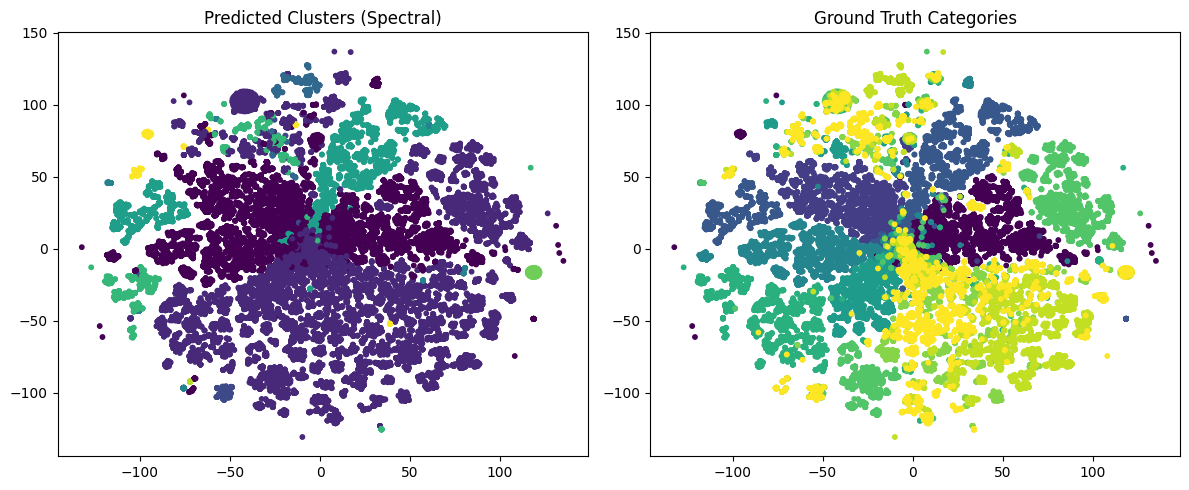

In [11]:
# 🧭 Run best config on full dataset + visualize
# --- Best configuration found from tuning ---
best_cfg = {
    "max_features": 1000,
    "min_df": 2,
    "svd_dim": None,
    "n_neighbors": 10,
    "assign_labels": "discretize",
    "ngram_range": (1, 2),
    "sublinear_tf": True,
}

print("Running best configuration on full dataset:")
print(best_cfg)

# --- 1) TF-IDF feature extraction ---
tfidf = TfidfVectorizer(
    max_features=best_cfg["max_features"],
    stop_words="english",
    min_df=best_cfg["min_df"],
    ngram_range=best_cfg["ngram_range"],
    sublinear_tf=best_cfg["sublinear_tf"],
)
X = tfidf.fit_transform(products["cleaned_title"])

# --- 2) Optional SVD dimensionality reduction --- 
X_reduced = X

# --- 3) Build symmetric k-NN graph (cosine distance) ---
A = kneighbors_graph(
    X_reduced,
    n_neighbors=best_cfg["n_neighbors"],
    mode="connectivity",
    metric="cosine",
    include_self=False,
    n_jobs=-1,
)
A = A.maximum(A.T)

# --- 4) Spectral Clustering ---
n_clusters = products["CategoryID"].nunique()
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",
    assign_labels=best_cfg["assign_labels"],
    random_state=42,
)
labels = spectral.fit_predict(A)

# --- 5) Evaluation ---
y_true = products["CategoryID"].to_numpy()
ari = adjusted_rand_score(y_true, labels)
nmi = normalized_mutual_info_score(y_true, labels)

print(f"\nClustering Performance on Full Dataset:")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# --- 6) Visualization (t-SNE for 2D projection) ---
print("\nRunning t-SNE for visualization (this may take ~1–2 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate="auto", init="random")
X_tsne = tsne.fit_transform(X_reduced)

# --- 7) Plot Predicted vs True Categories ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", s=10)
plt.title("Predicted Clusters (Spectral)")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=products["CategoryID"], cmap="viridis", s=10)
plt.title("Ground Truth Categories")

plt.tight_layout()
plt.show()


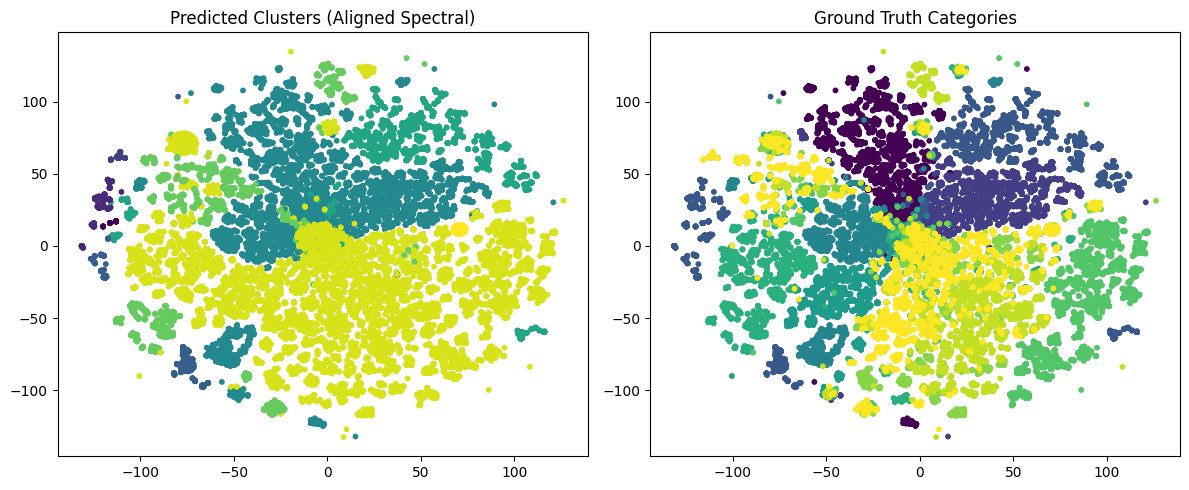

In [ ]:
# remap predicted cluster labels to best match the ground truth categories by maximizing label correspondence for better visualization

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm = confusion_matrix(y_true, labels)

# apply Hungarian algorithm to maximize matching
row_ind, col_ind = linear_sum_assignment(-cm)

# create mapping dictionary
mapping = {col: row for row, col in zip(row_ind, col_ind)}

# remap predicted labels
labels_aligned = np.array([mapping.get(l, l) for l in labels])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_aligned, cmap="viridis", s=10)
plt.title("Predicted Clusters (Aligned Spectral)")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, cmap="viridis", s=10)
plt.title("Ground Truth Categories")

plt.tight_layout()
plt.show()